In [3]:
import os
import warnings
base_path = os.path.abspath("../")
os.chdir(base_path)
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import eli5
import shap
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
plt.style.use('fivethirtyeight')

In [6]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [7]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

## S Learner

In [8]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.55696798])

In [9]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `gini`)

In [10]:
model_tau_feature = RandomForestRegressor()  # specify model for model_tau_feature
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

slearner.get_importance(X=X, tau=slearner_tau, model_tau_feature=model_tau_feature,
                        normalize=True, method='gini', features=feature_names)

{'treatment_A': stars         0.458352
 tiger         0.391570
 quixotic      0.035894
 merciful      0.027758
 fireman       0.022517
 rigid         0.003686
 playground    0.003664
 touch         0.003464
 sweltering    0.003448
 wrap          0.003318
 cute          0.003301
 damp          0.003287
 nonchalant    0.003217
 adhesive      0.003211
 lip           0.003180
 offer         0.003173
 dependent     0.003162
 lethal        0.003122
 clammy        0.003115
 change        0.002977
 future        0.002971
 rain          0.002963
 eight         0.002924
 shelf         0.002881
 barbarous     0.002844
 dtype: float64}

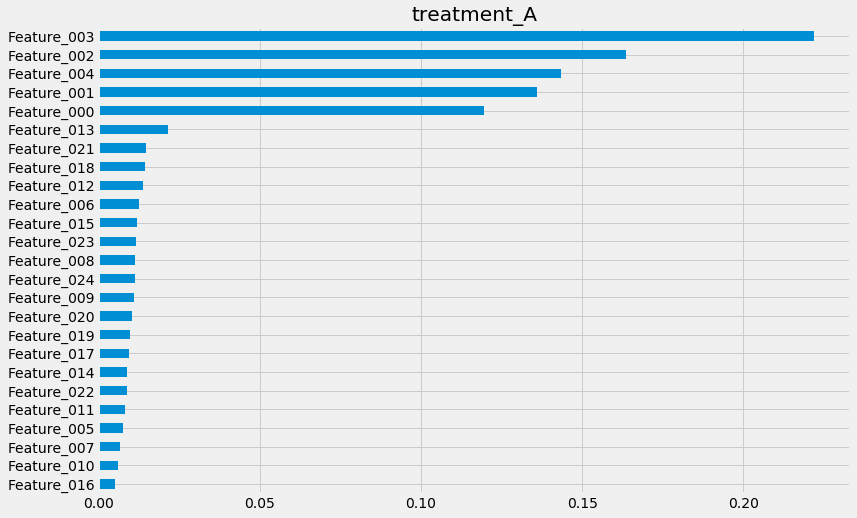

In [11]:
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [12]:
slearner.get_importance(X=X, tau=slearner_tau, method='permutation')

{'treatment_A': Feature_000    1.026825
 Feature_001    0.858229
 Feature_003    0.124688
 Feature_004    0.071862
 Feature_002    0.062152
 Feature_013    0.001230
 Feature_021    0.000623
 Feature_018    0.000454
 Feature_012    0.000188
 Feature_009    0.000112
 Feature_024    0.000104
 Feature_019    0.000082
 Feature_014    0.000057
 Feature_015    0.000048
 Feature_005    0.000042
 Feature_020    0.000034
 Feature_023    0.000021
 Feature_022    0.000004
 Feature_007    0.000003
 Feature_017   -0.000016
 Feature_006   -0.000018
 Feature_010   -0.000027
 Feature_011   -0.000042
 Feature_016   -0.000052
 Feature_008   -0.000066
 dtype: float64}

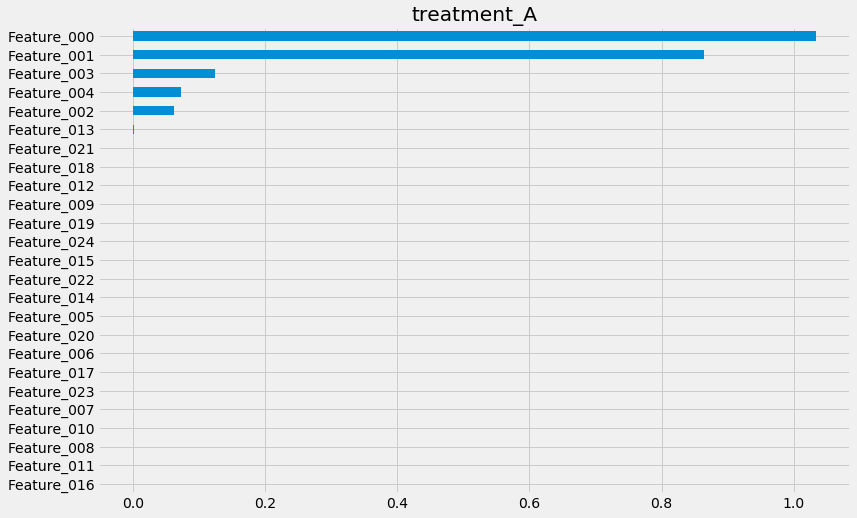

In [13]:
slearner.plot_importance(X=X, tau=slearner_tau, method='permutation')

### Shapley Values

In [14]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[-2.62801741e-01,  1.47054882e-01, -5.44693471e-02, ...,
          8.04229106e-04,  1.38762145e-03,  1.29386721e-03],
        [ 1.33815935e-01,  3.55033507e-02,  1.10198809e-02, ...,
          2.67035823e-03, -9.25465062e-04,  4.79804081e-04],
        [ 1.55403529e-01,  1.32491088e-01,  2.41434747e-02, ...,
          2.31199023e-05, -8.72058126e-04,  8.51601346e-05],
        ...,
        [-2.52279309e-01,  1.47917089e-02,  2.57090526e-02, ...,
         -5.90922769e-04, -1.37148121e-03, -2.40612766e-04],
        [ 1.32255986e-01,  1.62846122e-01,  1.79876165e-02, ...,
         -1.74024067e-04, -1.06355665e-05,  1.86795353e-03],
        [ 1.32193603e-01,  1.24351260e-01,  1.91876269e-02, ...,
         -2.19055671e-04, -6.41468233e-04, -1.44810637e-03]])}

In [15]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.16310256, 0.14325922, 0.02760414, 0.02868765, 0.02190604,
       0.00078423, 0.00058992, 0.00024027, 0.00084593, 0.00131289,
       0.00022343, 0.00032529, 0.00130646, 0.00176905, 0.00078938,
       0.0012268 , 0.00021439, 0.00038523, 0.00164807, 0.0008039 ,
       0.00086333, 0.00311217, 0.00064222, 0.00085213, 0.00079098])

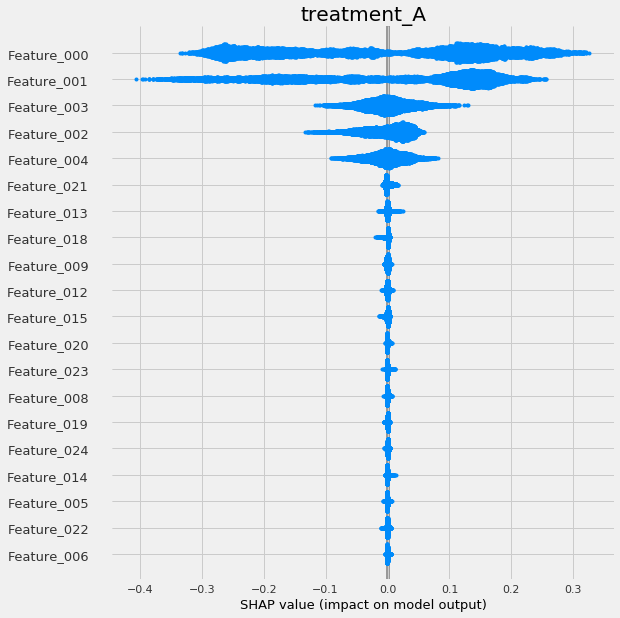

In [16]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau)

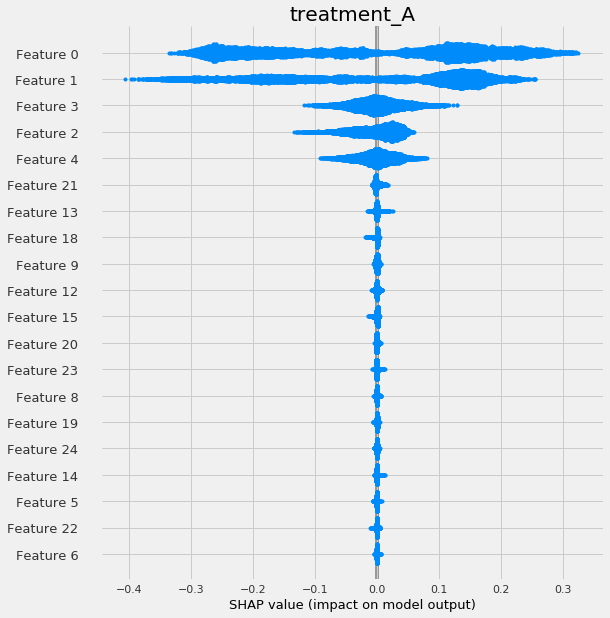

In [17]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(shap_dict=shap_slearner)

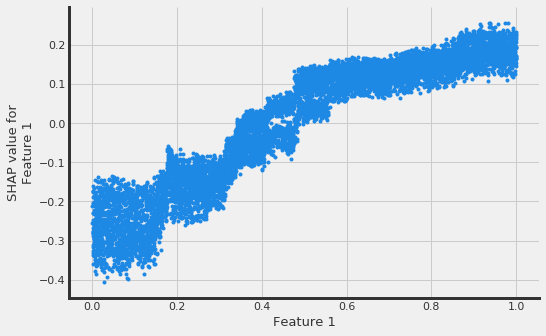

In [18]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

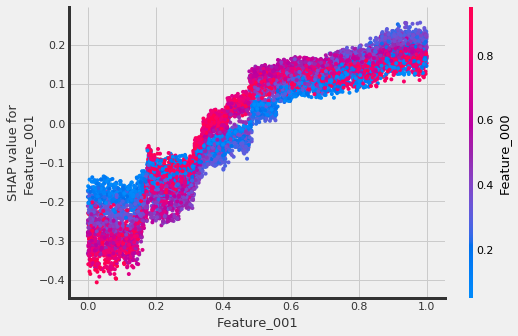

In [19]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto')

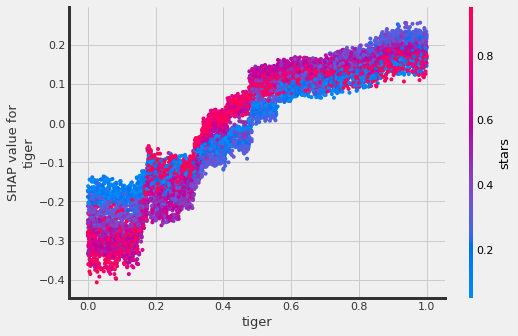

In [20]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

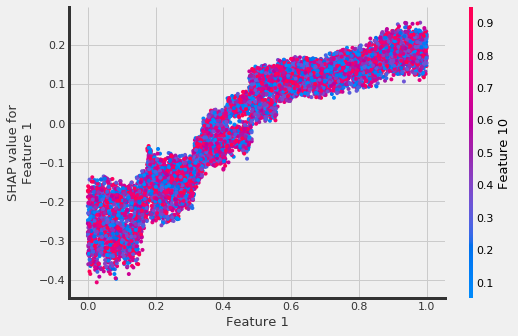

In [21]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner)

## T Learner

In [22]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.56098564]), array([0.54600461]), array([0.57596667]))

In [23]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `gini`)

In [24]:
tlearner.get_importance(X=X, tau=tlearner_tau, normalize=True, method='gini')

{'treatment_A': Feature_003    0.085667
 Feature_000    0.083667
 Feature_001    0.082333
 Feature_002    0.082333
 Feature_004    0.077667
 Feature_021    0.044000
 Feature_023    0.037667
 Feature_014    0.034333
 Feature_012    0.034000
 Feature_022    0.033000
 Feature_009    0.032333
 Feature_013    0.030667
 Feature_016    0.030333
 Feature_006    0.029000
 Feature_020    0.028333
 Feature_024    0.028333
 Feature_011    0.028000
 Feature_015    0.027667
 Feature_018    0.027333
 Feature_017    0.026333
 Feature_019    0.026000
 Feature_007    0.024333
 Feature_005    0.023667
 Feature_008    0.022000
 Feature_010    0.021000
 dtype: float64}

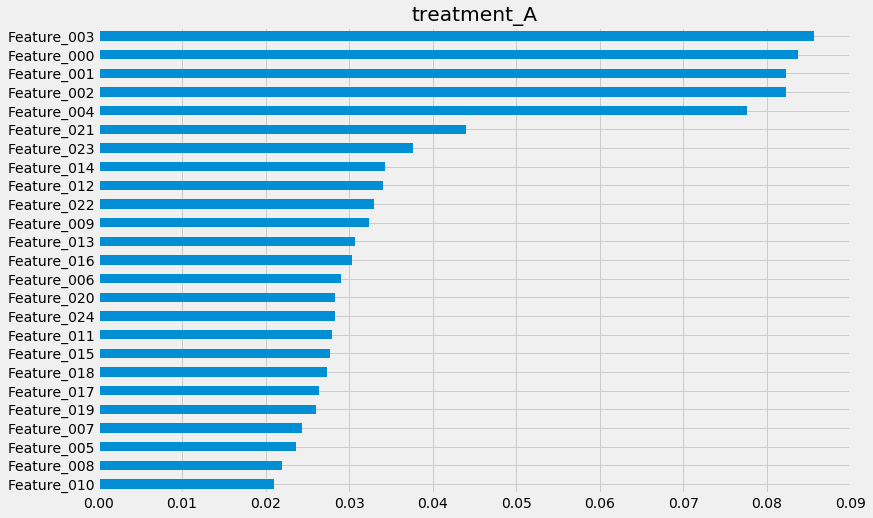

In [25]:
tlearner.plot_importance(X=X, tau=tlearner_tau, normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [26]:
tlearner.get_importance(X=X, tau=tlearner_tau, method='permutation')

{'treatment_A': Feature_000    0.670007
 Feature_001    0.495225
 Feature_003    0.045944
 Feature_004    0.029585
 Feature_002    0.023954
 Feature_021    0.013781
 Feature_023    0.013126
 Feature_022    0.008093
 Feature_013    0.006414
 Feature_014    0.005547
 Feature_012    0.004941
 Feature_024    0.004546
 Feature_009    0.004534
 Feature_008    0.004272
 Feature_005    0.003266
 Feature_006    0.003245
 Feature_011    0.003137
 Feature_018    0.003114
 Feature_020    0.002754
 Feature_015    0.002664
 Feature_017    0.002483
 Feature_016    0.002305
 Feature_019    0.002023
 Feature_007    0.001182
 Feature_010    0.001162
 dtype: float64}

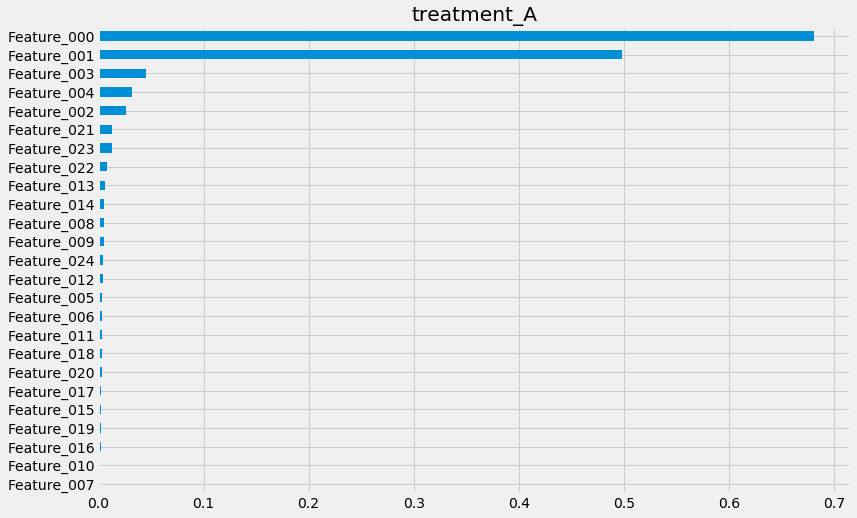

In [27]:
tlearner.plot_importance(X=X, tau=tlearner_tau, method='permutation')

### Shapley Values

In [28]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[-0.24273279,  0.24260105, -0.04318853, ...,  0.01945171,
          0.0608982 ,  0.00546009],
        [ 0.10169658,  0.01601504,  0.02326814, ...,  0.01447773,
         -0.02162543,  0.00788718],
        [ 0.16260392,  0.11251045,  0.00086613, ...,  0.01443641,
         -0.00303304, -0.00320545],
        ...,
        [-0.21390786,  0.02819327,  0.0275008 , ..., -0.00422203,
         -0.02848974, -0.00625311],
        [ 0.12930073,  0.15098682,  0.01548735, ..., -0.02631765,
         -0.00293609,  0.0183909 ],
        [ 0.13205767,  0.15483976,  0.02939619, ...,  0.01355007,
         -0.00168657, -0.01331412]])}

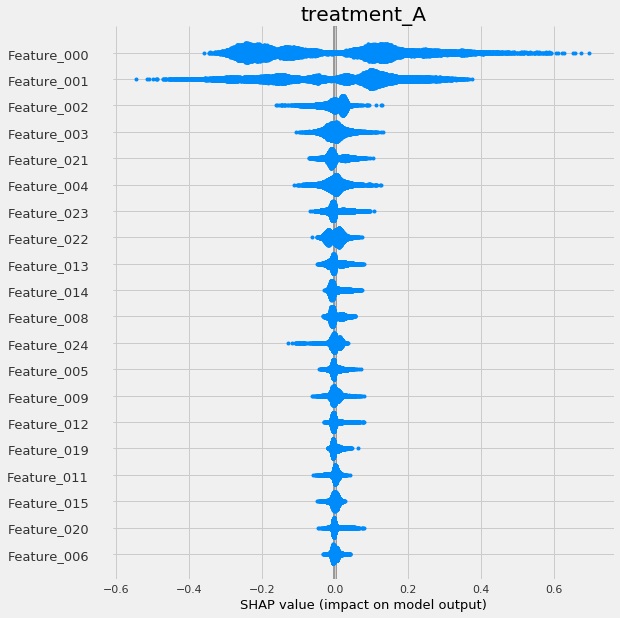

In [29]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau)

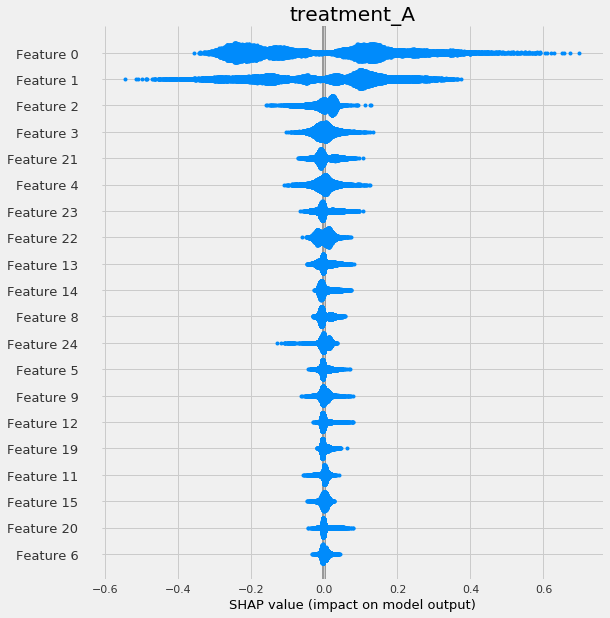

In [30]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(shap_dict=shap_tlearner)

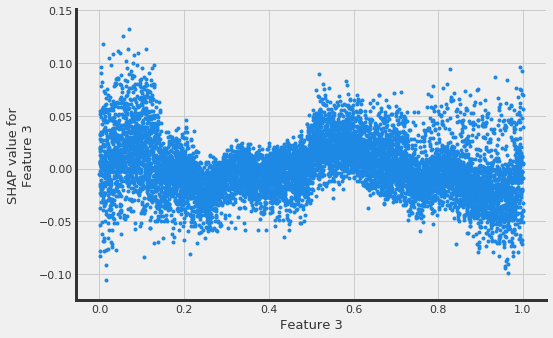

In [31]:
# interaction_idx set to None (no color coding for interaction effects)
tlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              tau=tlearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_tlearner)

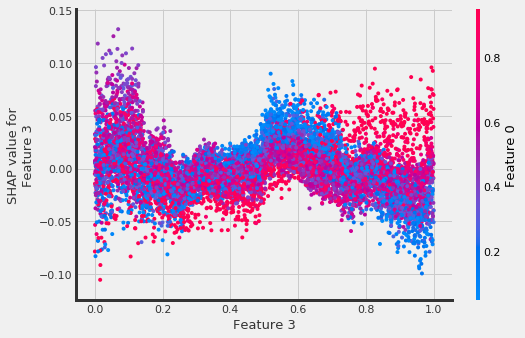

In [32]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
tlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              tau=tlearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_tlearner)

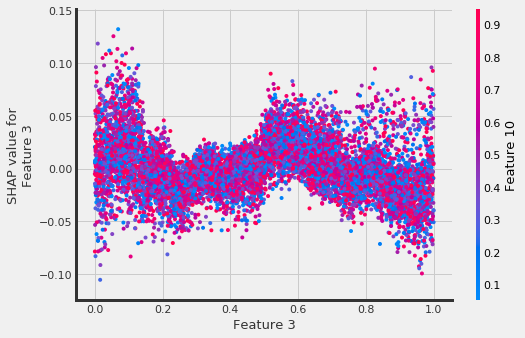

In [33]:
# interaction_idx set to specific index
tlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              tau=tlearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_tlearner)

## X Learner

In [34]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, e_multi, w_multi, y)

(array([0.50887043]), array([0.49471955]), array([0.52302131]))

In [35]:
xlearner_tau = xlearner.predict(X, e_multi, w_multi, y)

### Feature Importance (method = `gini`)

In [36]:
xlearner.get_importance(X=X, tau=xlearner_tau, normalize=True, method='gini')

{'treatment_A': Feature_001    0.100667
 Feature_000    0.094000
 Feature_002    0.068000
 Feature_021    0.053000
 Feature_004    0.045667
 Feature_014    0.044667
 Feature_022    0.040333
 Feature_023    0.038667
 Feature_013    0.037667
 Feature_003    0.037333
 Feature_005    0.037000
 Feature_020    0.035333
 Feature_008    0.034333
 Feature_012    0.033333
 Feature_009    0.032667
 Feature_018    0.032000
 Feature_011    0.030000
 Feature_006    0.029333
 Feature_024    0.027667
 Feature_016    0.027333
 Feature_017    0.027000
 Feature_019    0.025667
 Feature_007    0.023000
 Feature_010    0.022667
 Feature_015    0.022667
 dtype: float64}

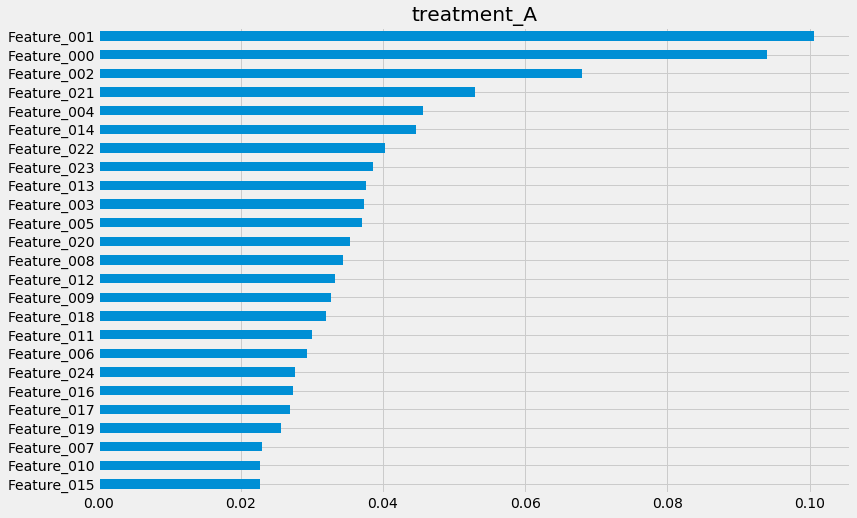

In [37]:
xlearner.plot_importance(X=X, tau=xlearner_tau, normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [38]:
xlearner.get_importance(X=X, tau=xlearner_tau, method='permutation')

{'treatment_A': Feature_000    0.924430
 Feature_001    0.633149
 Feature_021    0.024779
 Feature_002    0.022769
 Feature_023    0.022706
 Feature_013    0.015460
 Feature_014    0.014512
 Feature_003    0.014318
 Feature_022    0.013717
 Feature_005    0.011178
 Feature_004    0.011173
 Feature_008    0.005965
 Feature_016    0.005895
 Feature_006    0.005506
 Feature_018    0.005443
 Feature_020    0.005291
 Feature_024    0.004180
 Feature_012    0.004057
 Feature_011    0.003866
 Feature_009    0.003270
 Feature_015    0.002361
 Feature_017    0.002057
 Feature_010    0.001829
 Feature_019    0.001704
 Feature_007    0.000952
 dtype: float64}

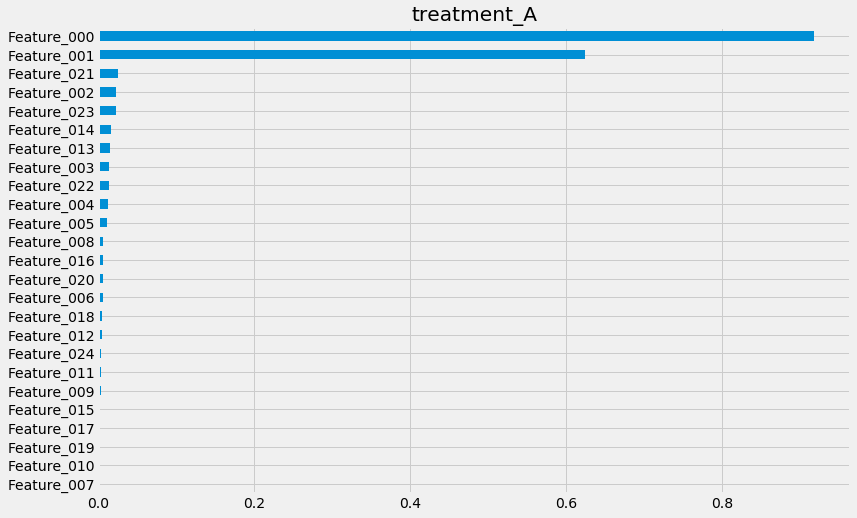

In [39]:
xlearner.plot_importance(X=X, tau=xlearner_tau, method='permutation')

### Shapley Values

In [40]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[-1.70630744e-01,  2.31731876e-01, -2.81434243e-02, ...,
          1.55445496e-02,  5.94083517e-02, -5.51694853e-04],
        [ 1.27589851e-01,  2.84367098e-02,  2.26350810e-02, ...,
          2.14763277e-02, -1.83620830e-02,  8.55192268e-03],
        [ 1.38226599e-01,  8.02927804e-02, -3.26579871e-03, ...,
          2.08303914e-02, -7.82390537e-03, -2.98365246e-03],
        ...,
        [-1.55832182e-01,  5.00318255e-02,  2.49536708e-02, ...,
          4.61714268e-06, -1.71899963e-02,  7.64602346e-04],
        [ 1.16386085e-01,  8.48507890e-02,  1.29704169e-02, ...,
         -3.59924200e-02, -1.09344044e-02,  7.30376269e-03],
        [ 1.78159944e-01,  1.98362721e-01,  2.75958158e-02, ...,
          2.04841198e-02, -6.63485269e-03, -6.71350117e-04]])}

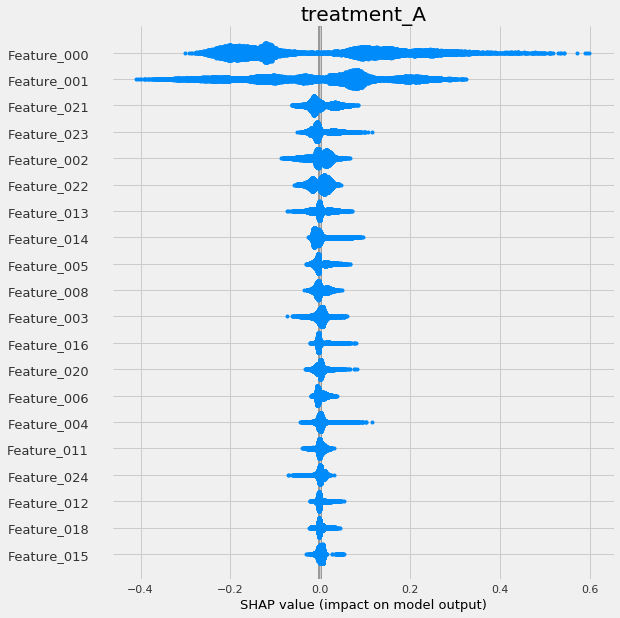

In [41]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau)

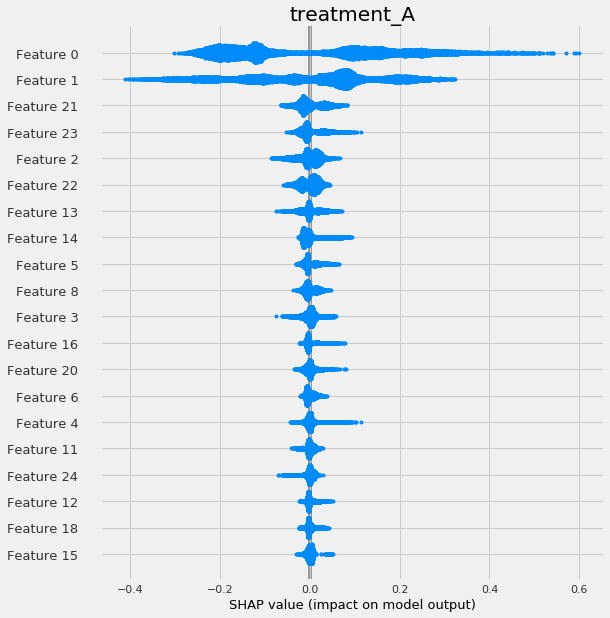

In [42]:
# shap_dict specified
xlearner.plot_shap_values(shap_dict=shap_xlearner)

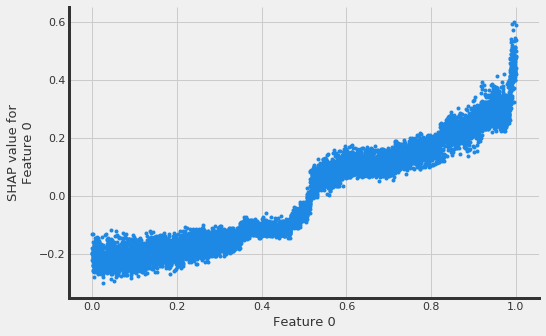

In [43]:
# interaction_idx set to None (no color coding for interaction effects)
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              tau=xlearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_xlearner)

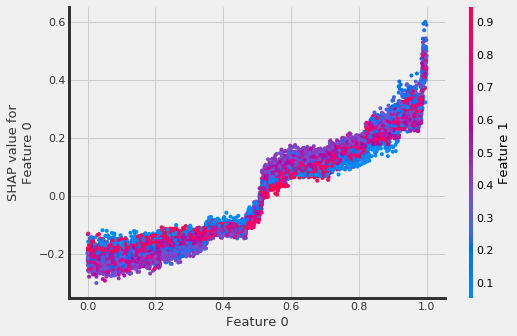

In [44]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              tau=xlearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_xlearner)

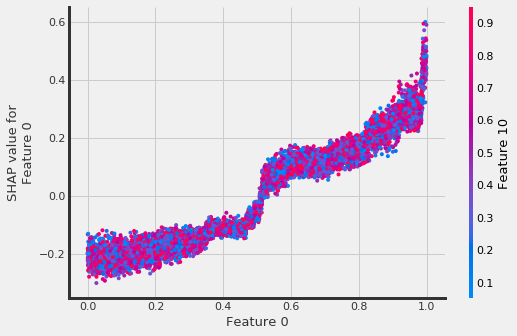

In [45]:
# interaction_idx set to specific index
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              tau=xlearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_xlearner)

## R Learner

In [46]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner.estimate_ate(X, e_multi, w_multi, y)

(array([0.51969614]), array([0.51946997]), array([0.51992231]))

In [47]:
rlearner_tau = rlearner.fit_predict(X, e_multi, w_multi, y)

### Feature Importance (method = `gini`)

In [48]:
rlearner.get_importance(X=X, tau=rlearner_tau, normalize=True, method='gini')

{'treatment_A': Feature_001    0.076000
 Feature_000    0.068667
 Feature_020    0.058667
 Feature_021    0.055333
 Feature_008    0.049667
 Feature_023    0.045667
 Feature_011    0.045333
 Feature_009    0.044000
 Feature_004    0.042667
 Feature_014    0.042000
 Feature_006    0.039000
 Feature_017    0.038333
 Feature_007    0.037667
 Feature_013    0.036333
 Feature_012    0.034000
 Feature_019    0.032667
 Feature_002    0.032667
 Feature_022    0.032000
 Feature_005    0.029667
 Feature_018    0.029333
 Feature_010    0.028667
 Feature_015    0.026667
 Feature_016    0.026667
 Feature_024    0.025000
 Feature_003    0.023333
 dtype: float64}

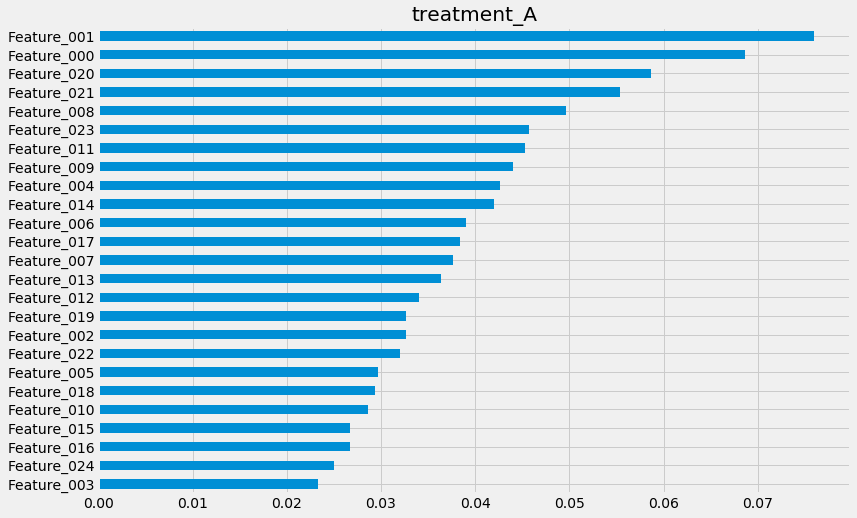

In [49]:
rlearner.plot_importance(X=X, tau=rlearner_tau, normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [50]:
rlearner.get_importance(X=X, tau=rlearner_tau, method='permutation')

{'treatment_A': Feature_000    0.475980
 Feature_001    0.283134
 Feature_023    0.038131
 Feature_021    0.028664
 Feature_020    0.024340
 Feature_014    0.021305
 Feature_008    0.021282
 Feature_005    0.018528
 Feature_017    0.017973
 Feature_006    0.015633
 Feature_011    0.013917
 Feature_007    0.013408
 Feature_022    0.013349
 Feature_009    0.012442
 Feature_002    0.011689
 Feature_013    0.010326
 Feature_004    0.010063
 Feature_019    0.008219
 Feature_010    0.007913
 Feature_012    0.006856
 Feature_024    0.005657
 Feature_016    0.005458
 Feature_015    0.004651
 Feature_018    0.004565
 Feature_003    0.002983
 dtype: float64}

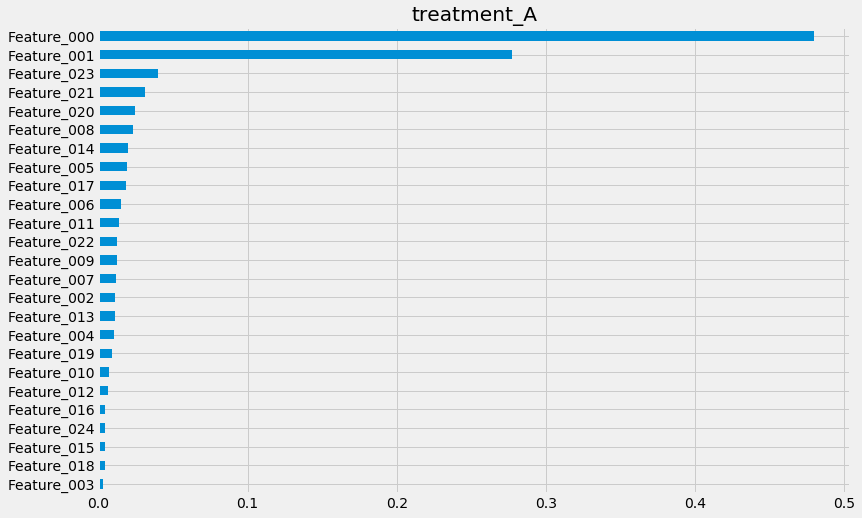

In [51]:
rlearner.plot_importance(X=X, tau=rlearner_tau, method='permutation')

### Shapley Values

In [52]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_A': array([[-1.67706231e-01,  2.32839657e-01, -3.43696236e-02, ...,
          7.68589930e-03,  1.23996464e-01,  1.85543201e-03],
        [ 4.55726991e-02, -3.68605128e-02,  6.02128678e-03, ...,
          2.24661583e-02, -4.94318957e-02,  8.50876661e-03],
        [ 1.37217871e-01,  7.31608359e-02, -2.46844847e-03, ...,
          2.17880928e-02, -1.35225039e-03, -1.11621294e-03],
        ...,
        [-1.21844165e-01,  4.51345419e-02,  1.72644748e-02, ...,
         -5.46314207e-05, -2.71614535e-02, -1.45152568e-03],
        [ 1.35005851e-01,  1.11433842e-01,  3.33362241e-03, ...,
         -3.17494192e-02, -1.23681033e-02,  2.46641769e-02],
        [ 1.96146734e-01,  2.16579265e-01,  2.00702881e-02, ...,
          2.10325738e-02,  7.41704924e-03, -1.79834421e-02]])}

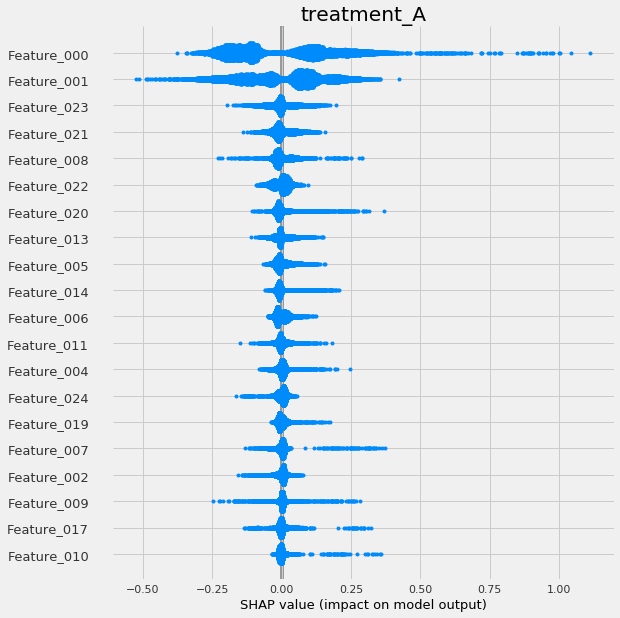

In [53]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau)

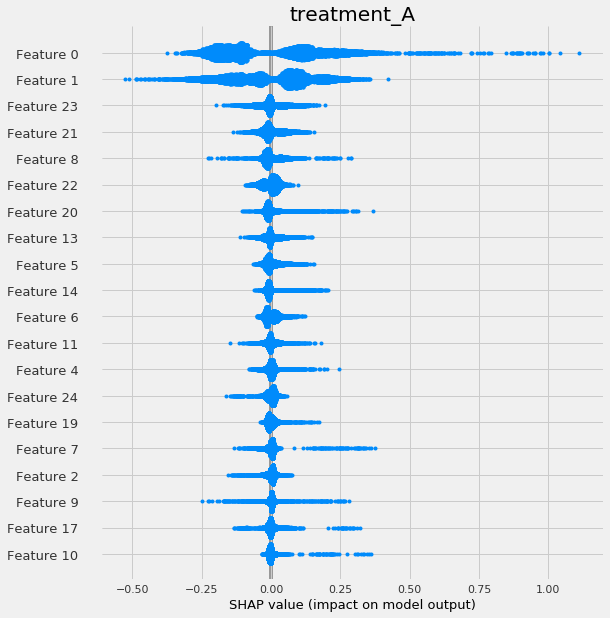

In [54]:
# with providing shap_dict
rlearner.plot_shap_values(shap_dict=shap_rlearner)

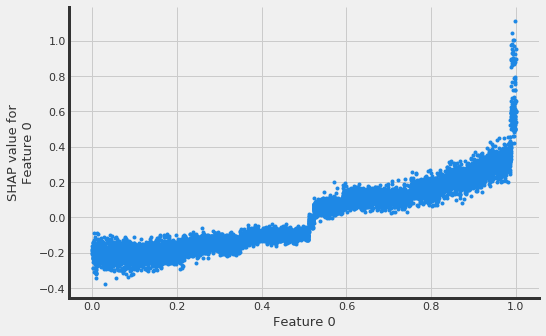

In [55]:
# interaction_idx set to None (no color coding for interaction effects)
rlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              tau=rlearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_rlearner)

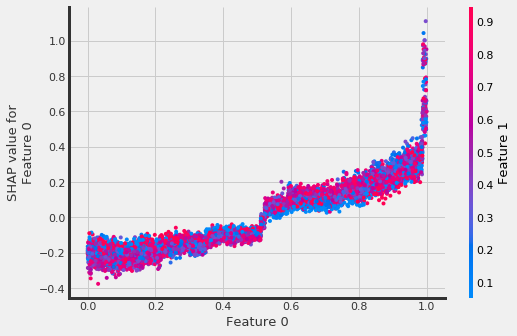

In [56]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
rlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              tau=rlearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_rlearner)

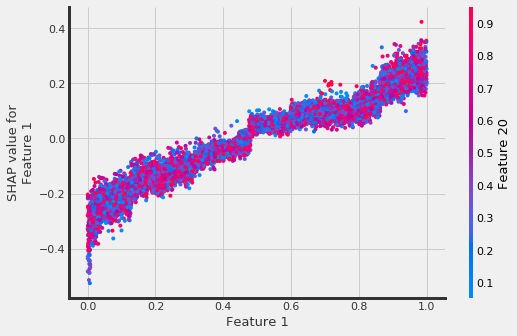

In [57]:
# interaction_idx set to specific index
rlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=rlearner_tau,
                              interaction_idx=20,
                              shap_dict=shap_rlearner)